In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)


Using device: gpu


In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR100(root="data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR100(root="data", train=False, download=True, transform=transform)

print("Classes:", train_dataset.classes)
print("Number of classes:", len(train_dataset.classes))


100%|██████████| 169M/169M [00:03<00:00, 52.6MB/s]


Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'will

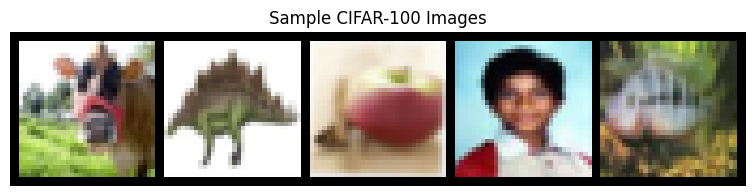


--- CIFAR-100 Structure ---
Classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

# Assuming train_dataset for CIFAR-100 is already defined from cell mB8pc7M2fSGi
# Get 5 images and labels from the CIFAR-100 train_dataset
# We need to create a temporary DataLoader for visualization if we want to ensure batching.
# Or we can just iterate through the dataset directly for individual items.

# For displaying, we might want to un-normalize if the dataset transform includes normalization
# However, for simply showing the structure and a grid, direct plotting of tensor might be sufficient
# Let's get the raw images before any transform that might resize them for display purposes.
# The `train_dataset` loaded in `mB8pc7M2fSGi` already has `transforms.ToTensor()` applied.
# So, the images will be 3x32x32.

# Create a DataLoader to get a batch of 5 images
display_loader = DataLoader(train_dataset, batch_size=5, shuffle=False)
images, labels = next(iter(display_loader))

plt.figure(figsize=(10,2))
# Permute the dimensions from CxHxW to HxWxC for matplotlib
plt.imshow(make_grid(images, nrow=5).permute(1,2,0))
plt.axis("off")
plt.title("Sample CIFAR-100 Images")
plt.show()

print("\n--- CIFAR-100 Structure ---")
print("Classes:", train_dataset.classes)
print("Number of classes:", len(train_dataset.classes))

# Get a sample image and its label to show shape
img, label = train_dataset[0]
print("Sample Image tensor shape:", img.shape)
print("Sample Label value:", label)
print("Sample Label name:", train_dataset.classes[label])

In [ ]:
!pip install timm

In [ ]:

import math, time, os, copy, random
from typing import List
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.transforms import RandAugment
from tqdm import tqdm

# ---------------------------
#  Helpers / Utilities
# ---------------------------
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append((correct_k / batch_size).item() * 100.0)
        return res


In [ ]:
# MixUp
def mixup_data(x, y, alpha=1.0, device='cuda'):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


In [ ]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [ ]:
# ---------------------------
#  Model Components
# ---------------------------

class AddEmbedding(nn.Module):
    """
    Progressive overlapping conv-based tokenization (simple version of OUTE).
    Stage kernels: [7, 3, 3] with overlaps approximated via padding and stride.
    Produces tokens (B, N, C) where N ~ tokens count, C = embed_dim
    """
    def __init__(self, in_ch=3, embed_dim=192):
        super().__init__()
        # Stage1: larger receptive field
        self.conv1 = nn.Conv2d(in_ch, embed_dim//2, kernel_size=7, stride=2, padding=3)  # downsample
        self.bn1 = nn.BatchNorm2d(embed_dim//2)
        # Stage2
        self.conv2 = nn.Conv2d(embed_dim//2, embed_dim//2, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(embed_dim//2)
        # Stage3 -> produce final embed_dim
        self.conv3 = nn.Conv2d(embed_dim//2, embed_dim, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(embed_dim)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # x: B,3,H,W (CIFAR:32x32)
        B = x.shape[0]
        x = F.gelu(self.bn1(self.conv1(x)))    # B, embed_dim/2, H/2, W/2
        x = F.gelu(self.bn2(self.conv2(x)))    # keep spatial
        x = F.gelu(self.bn3(self.conv3(x)))    # B, embed_dim, H/2, W/2

        B, C, H, W = x.shape
        n = H * W
        x = x.flatten(2).transpose(1, 2)       # B, N, C
        x = self.proj(x)
        cls_tok = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tok, x], dim=1)    # B, N+1, C
        x = self.norm(x)
        return x, (H, W)


In [ ]:
class CLPA_MSA(nn.Module):
    """
    Compute attention manually, extract attention maps; perform cross-layer predictive blend.
    - heads: number of heads
    - alpha: blending ratio between aggregated past attention and current attention
    """
    def __init__(self, dim, heads=4, dim_head=48, dropout=0.0, alpha=0.5):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        inner_dim = dim_head * heads
        self.to_q = nn.Linear(dim, inner_dim, bias=False)
        self.to_k = nn.Linear(dim, inner_dim, bias=False)
        self.to_v = nn.Linear(dim, inner_dim, bias=False)
        self.to_out = nn.Linear(inner_dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = dim_head ** -0.5
        self.alpha = alpha

    def forward(self, x, attn_history: List[torch.Tensor]):
        """
        x: B, N, C
        attn_history: list of attention maps (each: B, heads, N, N) from previous blocks in this forward pass
        returns: out: B,N,C ; current_attention (B,heads,N,N)
        """
        B, N, C = x.shape
        q = self.to_q(x).view(B, N, self.heads, self.dim_head).transpose(1,2)  # B,heads,N,dim_head
        k = self.to_k(x).view(B, N, self.heads, self.dim_head).transpose(1,2)
        v = self.to_v(x).view(B, N, self.heads, self.dim_head).transpose(1,2)

        # compute raw attention
        # q @ k^T : (B,heads,N,dim_head) @ (B,heads,dim_head,N) -> B,heads,N,N
        attn_cur = torch.matmul(q, k.transpose(-2,-1)) * self.scale
        attn_cur = F.softmax(attn_cur, dim=-1)

        # aggregate previous attention maps (if provided)
        if attn_history and len(attn_history) > 0:
            # stack and average (alternative: weighted)
            stacked = torch.stack(attn_history, dim=0)   # num_hist, B, heads, N, N
            # mean over history axis
            attn_prev = stacked.mean(dim=0)
            # blend
            attn_blend = self.alpha * attn_prev + (1.0 - self.alpha) * attn_cur
            # renormalize
            attn = F.softmax(attn_blend, dim=-1)
        else:
            attn = attn_cur

        out = torch.matmul(attn, v)  # B,heads,N,dim_head
        out = out.transpose(1,2).contiguous().view(B, N, -1)  # B,N,inner_dim
        out = self.to_out(out)
        out = self.dropout(out)
        # return out and current attention map (detach to store in history if desired)
        return out, attn_cur.detach()   # store current unblended attention (like Add-Vit)


In [ ]:
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_mult=4, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * hidden_mult),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * hidden_mult, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class LocalityEnhancementBlock(nn.Module):
    """Simple local convolutional enhancement applied to token sequence (as in your plan)"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        # We'll do depthwise + pointwise on spatial map
        self.dw = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim)
        self.pw = nn.Conv2d(dim, dim, kernel_size=1)
        self.act = nn.GELU()
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, spatial_shape):
        # x: B, N, C (including cls)
        B, N, C = x.shape
        cls, tokens = x[:, :1, :], x[:, 1:, :]  # separate cls
        H, W = spatial_shape
        tokens = tokens.transpose(1,2).reshape(B, C, H, W)
        out = self.dw(tokens)
        out = self.pw(out)
        out = self.act(out)
        out = out.reshape(B, C, -1).transpose(1,2)  # B,N-1,C
        out = torch.cat([cls, out], dim=1)
        out = self.norm(out)
        return out


In [ ]:
class AddVitBlock_CLPA(nn.Module):
    def __init__(self, dim, heads=4, mlp_mult=4, dropout=0.0, alpha=0.5):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = CLPA_MSA(dim=dim, heads=heads, dim_head=dim//heads, dropout=dropout, alpha=alpha)
        self.norm2 = nn.LayerNorm(dim)
        self.ff = FeedForward(dim, hidden_mult=mlp_mult, dropout=dropout)
        self.local = LocalityEnhancementBlock(dim)

    def forward(self, x, spatial_shape, attn_history: List[torch.Tensor]):
        # x: B,N,C
        # 1. MSA with CLPA
        x_norm = self.norm1(x)
        attn_out, cur_attn = self.attn(x_norm, attn_history)  # attn_history are from earlier blocks in forward pass
        x = x + attn_out
        # 2. Locality enhancement
        x = x + self.local(x, spatial_shape)
        # 3. FFN
        x = x + self.ff(self.norm2(x))
        return x, cur_attn


In [ ]:
class AddVit_CLPA(nn.Module):
    def __init__(self, image_size=32, in_ch=3, embed_dim=192, depth=6, heads=4, mlp_mult=4, num_classes=100, alpha=0.5, dropout=0.0):
        super().__init__()
        self.embed = AddEmbedding(in_ch=in_ch, embed_dim=embed_dim)
        self.depth = depth
        self.blocks = nn.ModuleList([
            AddVitBlock_CLPA(dim=embed_dim, heads=heads, mlp_mult=mlp_mult, dropout=dropout, alpha=alpha)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        # init
        nn.init.trunc_normal_(self.head.weight, std=0.02)

    def forward(self, x):
        # returns logits
        B = x.shape[0]
        x, spatial_shape = self.embed(x)  # x: B, N+1, C
        # maintain local list of attention maps across blocks for CLPA within one forward pass
        attn_history = []
        cur_atts = []
        for blk in self.blocks:
            x, cur_attn = blk(x, spatial_shape, attn_history)
            # store cur_attn in history for subsequent blocks
            # cur_attn shape: B, heads, N, N
            attn_history.append(cur_attn)
            cur_atts.append(cur_attn)
        x = self.norm(x)
        cls = x[:, 0]   # use cls token
        logits = self.head(cls)
        # optionally return attention maps for analysis
        return logits, cur_atts


In [ ]:
# ---------------------------
#  Training / Evaluation
# ---------------------------

def get_cifar100_loaders(batch_size=128, num_workers=4, mixup_alpha=0.8):
    # CIFAR-100 normalization stats
    mean = (0.5071, 0.4865, 0.4409)
    std = (0.2673, 0.2564, 0.2762)
    train_transform = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        RandAugment(num_ops=2, magnitude=9),
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    test_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean, std),
    ])
    train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=train_transform)
    test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=test_transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    return train_loader, test_loader


In [ ]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch, mixup_alpha=0.8, clip_grad_norm=None):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    criterion = nn.CrossEntropyLoss()
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, (images, targets) in pbar:
        images = images.to(device)
        targets = targets.to(device)
        # MixUp
        inputs, targets_a, targets_b, lam = mixup_data(images, targets, alpha=mixup_alpha, device=device)
        optimizer.zero_grad()
        logits, _ = model(inputs)
        loss = mixup_criterion(criterion, logits, targets_a, targets_b, lam)
        loss.backward()
        if clip_grad_norm:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad_norm)
        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        total_loss += loss.item() * images.size(0)
        acc1 = accuracy(logits, targets, topk=(1,))[0]
        total_acc += acc1 * images.size(0) / 100.0
        pbar.set_description(f"Epoch {epoch} Loss {loss.item():.4f} Acc {acc1:.2f}")
    n = len(dataloader.dataset)
    return total_loss / n, (total_acc / n) * 100.0


In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_acc = 0.0
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Eval"):
            images = images.to(device)
            targets = targets.to(device)
            logits, _ = model(images)
            loss = criterion(logits, targets)
            total_loss += loss.item() * images.size(0)
            total_acc += accuracy(logits, targets, topk=(1,))[0] * images.size(0) / 100.0
    n = len(dataloader.dataset)
    return total_loss / n, (total_acc / n) * 100.0


In [ ]:

# ---------------------------
#  Runner
# ---------------------------
def run_training(
    epochs=120,
    batch_size=128,
    lr=3e-4,
    weight_decay=0.05,
    num_workers=4,
    device=None,
    save_dir='./checkpoints',
    alpha=0.5,
):
    device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
    os.makedirs(save_dir, exist_ok=True)
    train_loader, test_loader = get_cifar100_loaders(batch_size=batch_size, num_workers=num_workers)
    model = AddVit_CLPA(image_size=32, in_ch=3, embed_dim=192, depth=6, heads=6, mlp_mult=3, num_classes=100, alpha=alpha).to(device)
    print("Model params:", sum(p.numel() for p in model.parameters()) / 1e6, "M")

    # optimizer + scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = epochs * len(train_loader)
    def lr_lambda(current_step):
        warmup_steps = int(0.03 * total_steps)
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

    best_acc = 0.0
    best_model = None

    # 🔧 History lists
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(1, epochs+1):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(model, optimizer, scheduler, train_loader, device, epoch, mixup_alpha=0.8, clip_grad_norm=1.0)
        val_loss, val_acc = evaluate(model, test_loader, device)
        t1 = time.time()
        print(f"Epoch {epoch} time {t1-t0:.1f}s Train loss {train_loss:.4f} Train acc {train_acc:.2f} | Val loss {val_loss:.4f} Val acc {val_acc:.2f}")

        # 🔧 Store history
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # checkpoint best
        if val_acc > best_acc:
            best_acc = val_acc
            best_model = copy.deepcopy(model.state_dict())
            ckpt_path = os.path.join(save_dir, f'best_clpa_addvit_epoch{epoch}_acc{val_acc:.2f}.pth')
            torch.save({'epoch': epoch, 'state_dict': best_model, 'val_acc': val_acc}, ckpt_path)
            print(f"Saved best to {ckpt_path}")

    print("Training finished. Best val acc:", best_acc)

    # 🔧 Return model + history for plotting & evaluation
    return model, best_acc, train_losses, train_accs, val_losses, val_accs, test_loader

if __name__ == "__main__":
    # Colab-friendly defaults for T4
    best = run_training(
        epochs=120,         # change as needed (50-200)
        batch_size=128,     # T4 can handle 128 on CIFAR usually
        lr=3e-4,
        weight_decay=0.05,
        num_workers=4,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        save_dir='./checkpoints',
        alpha=0.5,          # CLPA blending factor (0=vanilla, 1=prev-only)
    )



Model params: 2.77978 M
Eval: 100%|██████████| 79/79 [00:17<00:00,  4.46it/s]
Epoch 1 time 226.4s Train loss 4.5195 Train acc 2.30 | Val loss 4.1645 Val acc 7.08
Saved best to ./checkpoints/best_clpa_addvit_epoch1_acc7.08.pth

Eval: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]
Epoch 2 time 227.5s Train loss 4.2147 Train acc 5.10 | Val loss 3.7797 Val acc 13.57
Saved best to ./checkpoints/best_clpa_addvit_epoch2_acc13.57.pth

Eval: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]
Epoch 3 time 227.9s Train loss 4.0242 Train acc 7.64 | Val loss 3.4959 Val acc 19.06
Saved best to ./checkpoints/best_clpa_addvit_epoch3_acc19.06.pth

Eval: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]
Epoch 4 time 227.8s Train loss 3.8391 Train acc 9.56 | Val loss 3.1675 Val acc 24.95
Saved best to ./checkpoints/best_clpa_addvit_epoch4_acc24.95.pth

Eval: 100%|██████████| 79/79 [00:17<00:00,  4.48it/s]
Epoch 5 time 227.8s Train loss 3.7374 Train acc 10.90 | Val loss 3.0399 Val acc 27.23
Saved best to ./c

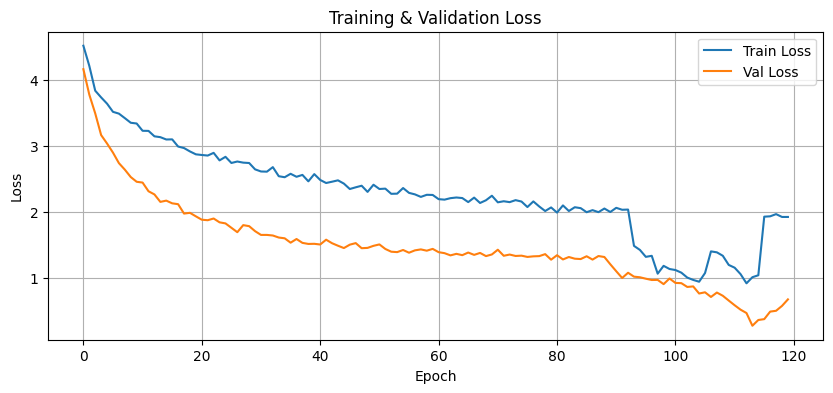

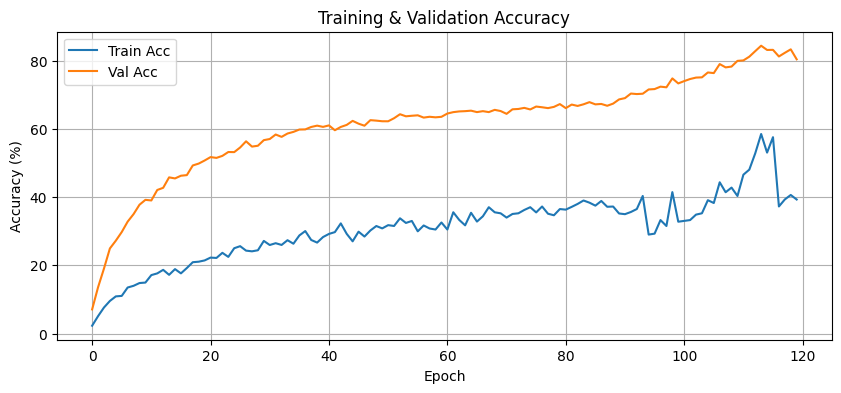

In [1]:
import matplotlib.pyplot as plt

# Unpack results from training
model, best_acc, train_losses, train_accs, val_losses, val_accs, test_loader = best

# Plot Loss
plt.figure(figsize=(10,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy
plt.figure(figsize=(10,4))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
